#### Imports


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import random
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

#### Functions

In [2]:
def read_data(file_name):
    data = pd.read_csv(file_name)
    feature_cols = []
    for label in data.columns:
        if label[0] == "X" or label[0] == "Y":
            feature_cols.append(label)
        elif label[0] == "R":
            break
    

    label_cols = ["ResultPositionX", "ResultPositionY", "ResultDirectionX", "ResultDirectionY"]
    x = data[feature_cols]
    y = data[label_cols]
    return x, y

In [207]:
def adjust_x_y(x, y):
    x_to_y_index = 0
    width = 2*3.7/64
    for i in range(len(x.columns)):
        if x.columns[i][0] == 'Y':
            x_to_y_index = i 
            break

    # min_x_strip_ID = x.iloc[:, 0:x_to_y_index].min().min()
    # min_y_strip_ID= x.iloc[:, x_to_y_index:(len(x.columns) // 2)].min().min()

    y['ResultPositionX'] = (y['ResultPositionX'] + 3.7) - x['XStripID1'] * width
    y['ResultPositionY'] = (y['ResultPositionY'] + 3.7) - x['YStripID1'] * width

    adj_x = x.copy()
    cols = list(adj_x.columns[:len(x.columns) // 2])
    adj_x = adj_x.drop(cols, axis=1)

    # adj_y = y.copy()
    adj_y = pd.DataFrame()
    adj_y["ResultDistanceMag"] = (y["ResultPositionX"]**2 + y["ResultPositionY"]**2)**(1/2)
    adj_y["ResultDistanceDir"] = np.atan(y["ResultPositionY"], y["ResultPositionX"])
    directionMag = (y["ResultDirectionX"] ** 2 + y["ResultDirectionY"] ** 2)**(1/2)
    adj_y["ResultDirectionX"] = y["ResultDirectionX"] / directionMag
    adj_y["ResultDirectionY"] = y["ResultDirectionY"] / directionMag
    adj_y["ResultDirection"] = np.degrees(np.atan(y["ResultDirectionY"], y["ResultDirectionX"]))

    

    return adj_x, adj_y


In [185]:
def train_model_normal(x_train, y_train, n_estimators=12, random_state=12345, verbose = 1):
    rf = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=23,
        min_samples_leaf=2,
        min_samples_split=4,
        max_features='sqrt',
        random_state=random_state, 
        verbose=verbose
    )
    rf.fit(
        x_train, y_train
    )
    return rf


In [ ]:
def test(rf, x_test, y_test):
    y_pred = rf.predict(x_test)
    distance = []
    direction = []
    
    for i in range(len(y_test)):
        dis_mag_t, dis_dir_t, dir_x_t, dir_y_t = y_test.iloc[i].iloc[0], y_test.iloc[i].iloc[1], y_test.iloc[i].iloc[2], y_test.iloc[i].iloc[3]
        dis_mag_p, dis_dir_p, dir_x_p, dir_y_p = y_pred[i][0], y_pred[i][1], y_pred[i][2], y_pred[i][3]
        dir_t= y_test.iloc[i].iloc[4]
        dir_p = y_pred[i][4]
        
        x_t = dis_mag_t * np.cos(dis_dir_t)
        y_t = dis_mag_t * np.sin(dis_dir_t)
        x_p = dis_mag_p * np.cos(dis_dir_p)
        y_p = dis_mag_p * np.sin(dis_dir_p)

        # error_x = y_test.iloc[i].iloc[0] - y_pred[i][0]
        # error_y = y_test.iloc[i].iloc[1] - y_pred[i][1]
        # distance.append(math.sqrt(error_x ** 2 + error_y**2))
        
        e_x = x_t - x_p
        e_y = y_t - y_p
        distance.append(math.sqrt(e_x**2 + e_y**2))
        direction.append(abs(dir_p - dir_t))

        # pred = np.array([dir_x_p, dir_y_p])
        # real = np.array([dir_x_t, dir_y_t])
        # cos_angle = np.dot(pred, real) / (np.linalg.norm(pred) * np.linalg.norm(real))
        # direction.append(math.degrees(math.acos(np.clip(cos_angle, -1.0, 1.0))))

    return distance, direction

In [127]:
def test_old(rf, x_test, y_test): 
    y_pred = rf.predict(x_test)
    distance = []
    direction = []
    
    for i in range(len(y_test)):
        error_x = y_test.iloc[i].iloc[0] - y_pred[i][0]
        error_y = y_test.iloc[i].iloc[1] - y_pred[i][1]
        distance.append(math.sqrt(error_x ** 2 + error_y**2))

        dp = y_test.iloc[i].iloc[2]  * y_pred[i][2] + y_test.iloc[i].iloc[3]  * y_pred[i][3]
        mag1 = math.sqrt(y_test.iloc[i].iloc[2] ** 2 + y_test.iloc[i].iloc[3] ** 2)
        mag2 = math.sqrt(y_pred[i][2] ** 2 + y_pred[i][3] ** 2)
        direction.append(math.degrees(math.acos(dp / mag1 / mag2)))

        # pred = np.array([y_pred[i][2], y_pred[i][3]])
        # real = np.array([y_test.iloc[i].iloc[2], y_test.iloc[i].iloc[3]])
        # cos_angle = np.dot(pred, real) / (np.linalg.norm(pred) * np.linalg.norm(real))
        # direction.append(math.degrees(math.acos(np.clip(cos_angle, -1.0, 1.0))))
        # direction.append(math.degrees(np.atan(pred) - np.atan(real)))

    return distance, direction

In [7]:
def train_number_of_trees(x_train, x_test, y_train, y_test, verbose=1):
    train_loss_dir = []
    test_loss_dir = []
    train_loss_dis = []
    test_loss_dis = []
    n_trees = np.linspace(10, 100, 7, dtype=int)

    rf = RandomForestRegressor(n_estimators=10, random_state=12345, warm_start=True, verbose=verbose)
    for n in n_trees:
        print(f"Running RandomForestRegressor on {n} trees")
        rf.n_estimators = n  # Increase number of trees
        rf.fit(x_train, y_train)  # Train the model incrementally

        distance_test, direction_test = test(rf, x_test, y_test)
        distance_train, direction_train = test(rf, x_train, y_train)
        
        test_loss_dir.append(np.average(direction_test))
        test_loss_dis.append(np.average(distance_test))
        train_loss_dir.append(np.average(direction_train))
        train_loss_dis.append(np.average(distance_train))
    
    plt.figure(figsize=(8, 5))
    plt.plot(n_trees, train_loss_dis, label="Training Distance MSE", marker="o")
    plt.plot(n_trees, test_loss_dis, label="Test Distance MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Distance Mean Squared Error (cm)")
    plt.title("Training and Test Loss Based on Number of Trees")
    plt.legend()


    plt.figure(figsize=(8, 5))
    plt.plot(n_trees, train_loss_dir, label="Training Direction MSE", marker="o")
    plt.plot(n_trees, test_loss_dir, label="Test Direction MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Direction Mean Squared Error (degrees)")
    plt.title("Training and Test Loss Based on Number of Trees")
    plt.legend()

    plt.show()

    return rf


In [ ]:
def train_depth(x_train, x_test, y_train, y_test, verbose = 1):
    train_loss_dir = []
    test_loss_dir = []
    train_loss_dis = []
    test_loss_dis = []
    depths = list(range(10, 51, 5))

    
    for depth in depths:
        print(f"Running RandomForestRegressor with depth {depth}")
        rf = RandomForestRegressor(n_estimators=40, random_state=12345, max_depth = depth, verbose=verbose)
        rf.fit(x_train, y_train)  # Train the model incrementally
        
        # Predict on training and test data
        distance_test, direction_test = test(rf, x_test, y_test)
        distance_train, direction_train = test(rf, x_train, y_train)
        
        # Store the errors
        test_loss_dir.append(np.average(direction_test))
        test_loss_dis.append(np.average(distance_test))
        train_loss_dir.append(np.average(direction_train))
        train_loss_dis.append(np.average(distance_train))

    plt.figure(figsize=(8, 5))
    plt.plot(depths, train_loss_dis, label="Training Distance MSE", marker="o")
    plt.plot(depths, test_loss_dis, label="Test Distance MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Distance Mean Squared Error (cm)")
    plt.title("Training and Test Loss Based on Depth of Trees")
    plt.legend()

    plt.figure(figsize=(8, 5))
    plt.plot(depths, train_loss_dir, label="Training Direction MSE", marker="o")
    plt.plot(depths, test_loss_dir, label="Test Direction MSE", marker="s")
    plt.xlabel("Number of Trees")
    plt.ylabel("Direction Mean Squared Error (degrees)")
    plt.title("Training and Test Loss Based on Depth of Trees")
    plt.legend()

    plt.show()

    return rf

#### Run the Model (Call Functions)

In [208]:
# set up model
data = "output_x3_y2.csv"
print("Reading Data...")
x, y = read_data(data)
print("Adjusting Data...")
x, y = adjust_x_y(x, y)
print("Split Data...")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 12345)
print("Done")

y

Reading Data...
Adjusting Data...
Split Data...
Done


,ResultDistanceMag,ResultDistanceDir,ResultDirectionX,ResultDirectionY,ResultDirection
0,0.080217,0.051594,-0.732580,0.680681,27.047948
1,0.093074,0.072269,0.920062,0.391772,19.282389
2,0.303264,0.118039,-0.972853,-0.231424,-12.732181
3,0.281598,0.146185,-0.329327,-0.944216,-43.314189
4,0.277700,0.028188,0.425953,0.904745,31.629331
...,...,...,...,...,...
15418,0.350039,0.089143,-0.373256,0.927728,4.020707
15419,0.364044,0.201757,-0.995363,0.096194,5.172318
15420,0.121798,0.121070,0.766663,-0.642049,-28.606726
15421,0.658366,0.461654,-0.181625,-0.983368,-44.370083


In [213]:
# run the model - normal
print("Training model...")
rf = train_model_normal(x_train, y_train, verbose = 1)
print("Validating model...")
distance, direction = test(rf, x_test, y_test)
print("Done")

Training model...
Validating model...
Done


#### Plots + Results

Average distance: 0.07436992722512602


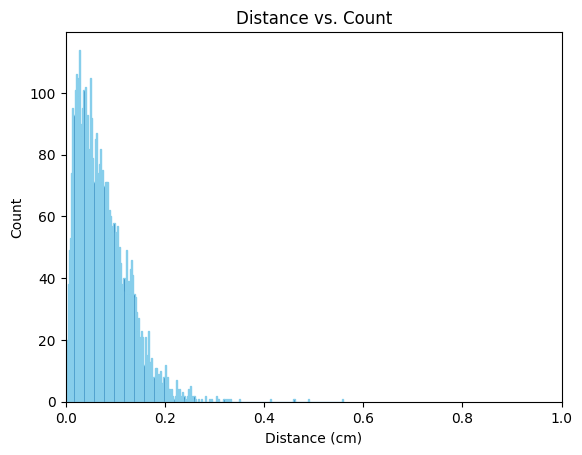

In [214]:
# Plots Distance vs Count

print("Average distance:", np.average(distance))
plt.hist(distance, bins=250, edgecolor='skyblue')
bottom, top = plt.ylim()
# plt.ylim(0, 10)
plt.xlim(0, 1)
plt.xlabel('Distance (cm)')
plt.ylabel('Count')
plt.title('Distance vs. Count')
plt.show()

Average direction: 22.217223527965743
Standard devation: 13.885329084722585


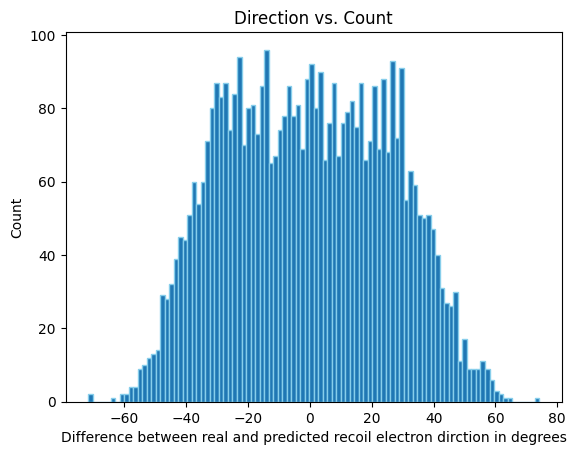

In [215]:
# Plots Direction vs Count
print("Average direction:", np.average(direction))
print("Standard devation:", np.std(direction))

r_direction = direction.copy()
for i in range(len(r_direction)):
    r_direction[i] *= random.choice([1, -1])

plt.hist(r_direction, bins=100, edgecolor='skyblue')
plt.xlabel('Difference between real and predicted recoil electron dirction in degrees')
plt.ylabel('Count')
plt.title('Direction vs. Count')
plt.show()

#### Effect of Hyperparameters on Result

In [216]:
# set up model
data = "output_x2_y2.csv"
print("Reading Data...")
x, y = read_data(data)
print("Adjusting Data...")
x, y = adjust_x_y(x, y)
print("Split Data...")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 12345)
print("Done")

y

Reading Data...
Adjusting Data...
Split Data...
Done


,ResultDistanceMag,ResultDistanceDir,ResultDirectionX,ResultDirectionY,ResultDirection
0,0.149779,0.015259,-0.610155,0.792282,33.366103
1,0.091197,0.058329,0.413402,0.910549,42.263307
2,0.205485,0.150386,0.311954,-0.950097,-27.533932
3,0.113182,0.068667,0.153132,0.988206,44.626017
4,0.133804,0.079462,-0.876521,0.481364,24.633350
...,...,...,...,...,...
52380,0.170169,0.030316,0.966432,0.256922,3.312584
52381,0.045011,0.044595,0.778356,0.627823,32.119369
52382,0.212330,0.103885,-0.569083,-0.822280,-39.412340
52383,0.168563,0.058892,-0.532017,0.846734,38.065916


Training model...
Running RandomForestRegressor on 10 trees
Running RandomForestRegressor on 25 trees
Running RandomForestRegressor on 40 trees
Running RandomForestRegressor on 55 trees
Running RandomForestRegressor on 70 trees
Running RandomForestRegressor on 85 trees
Running RandomForestRegressor on 100 trees


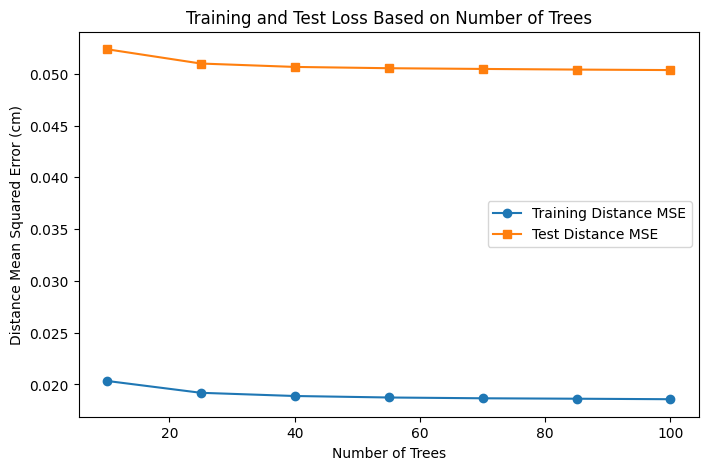

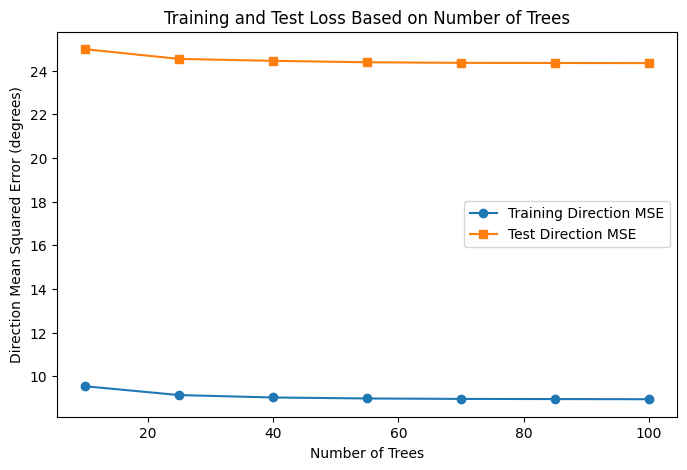

Validating model...
Done


In [217]:
#actually run the model - see effect of # of trees
print("Training model...")
rf = train_number_of_trees(x_train, x_test, y_train, y_test, verbose = 0)
print("Validating model...")
distance, direction = test(rf, x_test, y_test)
print("Done")

Training model...
Running RandomForestRegressor with depth 10
Running RandomForestRegressor with depth 15
Running RandomForestRegressor with depth 20
Running RandomForestRegressor with depth 25
Running RandomForestRegressor with depth 30
Running RandomForestRegressor with depth 35
Running RandomForestRegressor with depth 40
Running RandomForestRegressor with depth 45
Running RandomForestRegressor with depth 50


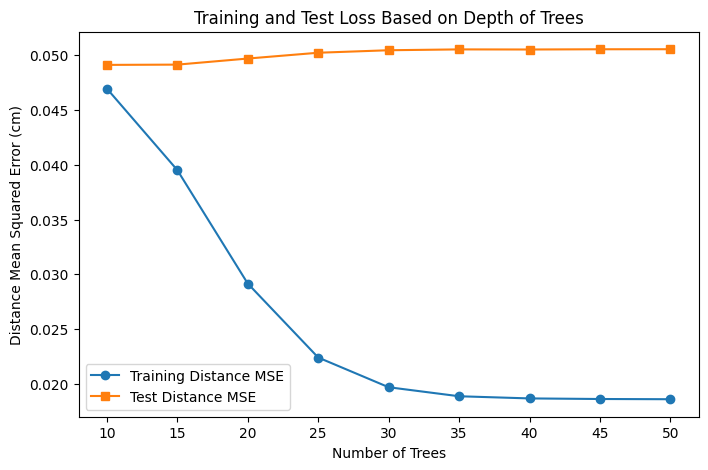

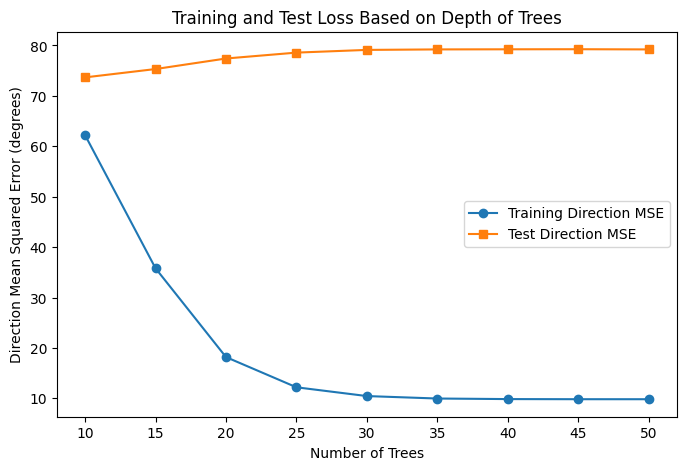

Validating model...


In [134]:
# run the model - see effect of # of tree splits
print("Training model...")
rf = train_depth(x_train, x_test, y_train, y_test, verbose = 0)
print("Validating model...")
distance, direction = test(rf, x_test, y_test)
print("Done")